In [5]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
using Printf
using Plots
using ColorTypes

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 100.00
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 100.00
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    # Printing the matrix with formatting
    for i in 1:length(x)
        for j in 1:length(x)
            @printf "%-5.2f  " distances[i, j]
        end
        println()
    end
    
    return distances

end

function generate_rgb_colors(l::Int)
    colors = [RGB(rand(), rand(), rand()) for _ in 1:l]
    return colors
end

generate_rgb_colors (generic function with 1 method)

In [101]:
function displayMap()
    node_labels = [string("N.", i) for i in N]
    # demand_labels = [string("D= ", D[i-1-np]," TW= ",TW[i-1-np]) for i in C]
    
    # Add the depot point in a different color
    p = scatter([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow,size=(850, 600),legend = false)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :blue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white)
        end
    end
    
    # Add the customer point in a different color
    scatter!([x_coor[2+np:1+nc+np]], [y_coor[np+2:1+nc+np]], 
             markersize = 8, markercolor = :pink, marker=:utriangle)
    
    # Add annotations for each node
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 8))
    end 
end

displayMap (generic function with 1 method)

In [103]:
# Number of customers
nc = 6
# Coordinate x (Depot then parking places then customers)
x_coor = [4,11,0,8,4, 0,4,3,10,3,8,10,6]
# Coordinate y (Depot then parking places then customers)
y_coor = [4,-1,8,8,0, 2,10,11,10,0, 11,8,1]
# Number of parking places
np = length(x_coor)-1-nc
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np
A2 = 2 : 1+np+nc
V1 = 1 : 1 #Set of FEV
V2 = 1 : 2 #Set of SEV
N = 1 : length(x_coor)
Q0 = 100
Q1 = 60
Q2 = 20
D = [15,15,10,8,2,20]
M = 10000
TW = [(10,20),(10,20),(10,20),(10,20),(10,20),(10,20)] 
PI = [1,1,1,1,0,0]
eta1 = 1
eta2 = 3
zeta = 50

50

100.00  8.60   5.66   5.66   4.00   4.47   6.00   100.00  100.00  100.00  100.00  100.00  100.00  
8.60   100.00  14.21  9.49   7.07   11.40  13.04  14.42  11.05  8.06   12.37  9.06   5.39   
5.66   14.21  100.00  8.00   8.94   6.00   4.47   4.24   10.20  8.54   8.54   10.00  9.22   
5.66   9.49   8.00   100.00  8.94   10.00  4.47   5.83   2.83   9.43   3.00   2.00   7.28   
4.00   7.07   8.94   8.94   100.00  4.47   10.00  11.05  11.66  1.00   11.70  10.00  2.24   
4.47   11.40  6.00   10.00  4.47   100.00  8.94   9.49   12.81  3.61   12.04  11.66  6.08   
6.00   13.04  4.47   4.47   10.00  8.94   100.00  1.41   6.00   10.05  4.12   6.32   9.22   
100.00  14.42  4.24   5.83   11.05  9.49   1.41   100.00  7.07   11.00  5.00   7.62   10.44  
100.00  11.05  10.20  2.83   11.66  12.81  6.00   7.07   100.00  12.21  2.24   2.00   9.85   
100.00  8.06   8.54   9.43   1.00   3.61   10.05  11.00  12.21  100.00  12.08  10.63  3.16   
100.00  12.37  8.54   3.00   11.70  12.04  4.12   5.00   2.24

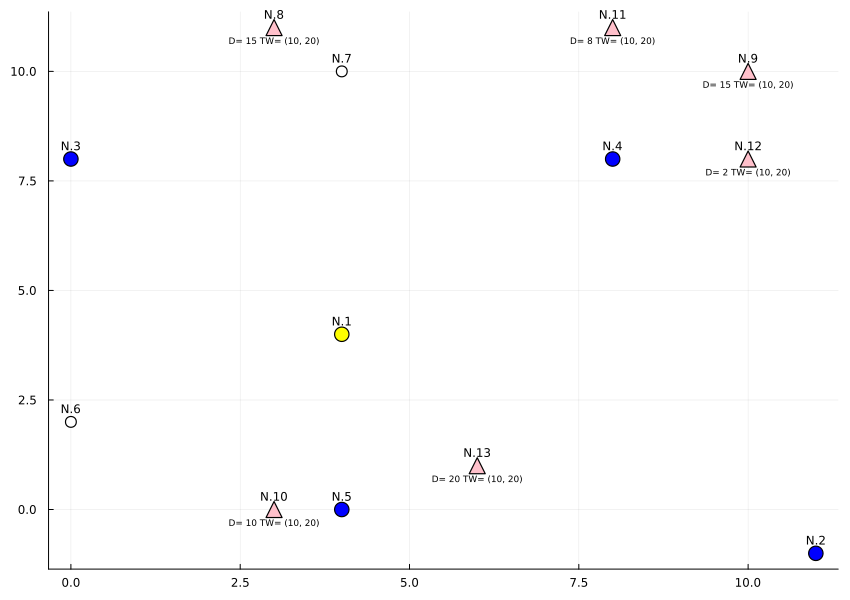

In [115]:
# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)
Vitesse1 = 2
Vitesse2 = 1
println(" ")
TT1 = (distances / Vitesse1)
TT2 = (distances / Vitesse2)

displayMap()
demand_labels = [string("D= ", D[i-1-np]," TW= ",TW[i-1-np]) for i in C]
for i in C
    annotate!(x_coor[i], y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 
plot!()

In [91]:
#=========================================================================#
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A2]>=0, Int) #Arrival time

@variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

@variable(model, z[V2,A2,A2], Bin)#Arc(x,y) traversed by SEV
for m in V2
    for i in A2
        @constraint(model, z[m,i,i] == 0)
        for j in A2
            if i in P && j in P
                @constraint(model, z[m,i,j]==0)
            end
        end
    end
end

@variable(model, f[A2,A2]>=0,Int) #Load of SEV
#=================================================================================================#
@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(sum(distances[i, j] * z[r, i, j] for i in A2, j in A2 if i != j) for r in V2))
#=================================================================================================#

#1 #2
#Flow conservation at parking for FEV
@constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
@constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)
#3
#Flow conservation of MM
@constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)
#4
#Limit for mobile microhub
@constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])

#5 #6
#Flow conservation at depot
@constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
@constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)
@constraint(model, [i in A1], y[1,i] ==0)
@constraint(model, [i in A1], y[i,1] ==0)

#7
#Capacity limit for FEV
@constraint(model, sum(w[p] for p in P)<=Q0)

#8
#Can't tow a MM from parking without MM
@constraint(model, [i in P], sum(y[i,j] for j in A1)<= PI[i-1])
#9
#Can't tow a MM to a parking occupied
@constraint(model, [j in P], sum(y[i,j] for i in A1)<=1-PI[j-1])
#10
#If MM leaves a site, the freight to the site should be zero, otw could be positive
@constraint(model, [p in P], w[p]<=Q1*(1-sum(y[p,j] for j in A1)))

#11
#Link 1st and 2nd
@constraint(model, [p in P], w[p] == sum(f[p,j] for j in A2 if p !=j))

#12
#Capacity limit for MM and connection of FEV
@constraint(model, [p in P], w[p] <= Q1*sum(x[i,p] for i in A1))
#13
#Can't distribute from a site without MM
@constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p-1]))

#14
#Flow consercvation at parking and customer for SEV
@constraint(model, [i in A2, r in V2], sum(z[r,i,j] for j in A2) == sum(z[r,j,i] for j in A2))
#15
#Number of vehicles depart from a Parking node
@constraint(model, [p in P], sum(z[r,p,j] for j in A2 for r in V2) <= length(V2))
#16
#Flow conservation at customer node for SEV
@constraint(model, [i in C], sum(z[r,i,j] for j in A2 for r in V2) == 1)
#17
#Each SEV departs from parking node at most once
@constraint(model, [r in V2, p in P], sum(z[r,p,j] for j in A2) <= 1)
#18
#Customer demand met
@constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2)==D[i-1-np])
#19
#Connection and capacity limit for SEV
@constraint(model, [i in A2, j in A2], f[i,j] <= Q2 * sum(z[r,i,j] for r in V2))

#20
@constraint(model, sum(TT1[i,j]*x[i,j] for i in A1 for j in A1) + eta1*sum(PI[p-1]*x[i,p] for p in P for i in A1)<= zeta)

#21
@constraint(model, [i in C, j in P, r in V2], t[i]+TT2[i,j]+eta2 <= zeta + M*(1 - z[r,i,j]))
#22
#Time constraint for FEV and MTZ
@constraint(model, [i in P, j in P], t[i] + eta1*(1-x[i,j]) + TT1[i,j]*x[i,j] <= t[j] + M*(1 - x[i,j]))

#23
#Time constraint for SEV and MTZ
@constraint(model, [i in C, j in C, r in V2], t[i]+eta2*(1-z[r,i,j])+TT2[i,j]*z[r,i,j] <= t[j]+M * (1 - z[r,i,j]))

#24
@constraint(model, [i in C], t[i] >= TW[i-1-np][1])
@constraint(model, [i in C], t[i] <= TW[i-1-np][2])

#25 26
#Arrival time initialization
@constraint(model, [i in P], TT1[1,i] * x[1,i] <= t[i])
@constraint(model, [p in P, j in C, r in V2], t[p] + TT2[p,j] * z[r,p,j] <= t[j])

3-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},3,...} with index sets:
    Dimension 1, 8:13
    Dimension 2, 2:7
    Dimension 3, 1:2
And data, a 6×6×2 Array{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}, 3}:
[:, :, 1] =
 t[8] + 10000 z[1,8,2] ≤ 10032.577794898145    …  t[8] + 10000 z[1,8,7] ≤ 10045.585786437627
 t[9] + 10000 z[1,9,2] ≤ 10035.954638982812       t[9] + 10000 z[1,9,7] ≤ 10041
 t[10] + 10000 z[1,10,2] ≤ 10038.937742251701     t[10] + 10000 z[1,10,7] ≤ 10036.95012437888
 t[11] + 10000 z[1,11,2] ≤ 10034.630683123147     t[11] + 10000 z[1,11,7] ≤ 10042.876894374382
 t[12] + 10000 z[1,12,2] ≤ 10037.944614861863     t[12] + 10000 z[1,12,7] ≤ 10040.675444679664
 t[13] + 10000 z[1,13,2] ≤ 10041.614835192866  …  t[13] + 10000 z[1,13,7] ≤ 10037

In [93]:
# Solve the model
optimize!(model)

# Check solution status and display results
if termination_status(model) == MOI.OPTIMAL
    println("Total distance traveled: ", objective_value(model))
    for i in A1
        for j in A1 if round(value(x[i,j]))==1 print("  x[",i,",",j,"]=",round(value(x[i,j]))) end end
    end
    println(" ")
    for i in A1
        for j in A1 if value(y[i,j])==1 print("  y[",i,",",j,"]=",value(y[i,j])) end end
    end
    println(" ")
    for i in A2 print("  t[",i,"]=",value(t[i])) end
    println(" ")
    for r in V2
        for i in A2
            for j in A2 if round(value(z[r,i,j]))==1 print("  z[",r,",",i,",",j,"]=",round(value(z[r,i,j]))) end end
        end
        println("")
    end
    println(" ")
    for i in P
        print("  w[",i,"]=",value(w[i]))
    end
    println(" ")
    for i in A2
        for j in A2 if value(f[i,j]) != 0 print("  f[",i,",",j,"]=",value(f[i,j])) end end
    end
else
    println("No feasible solution found.")
end

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
Tried aggregator 1 time.
MIP Presolve eliminated 369 rows and 210 columns.
MIP Presolve modified 308 coefficients.
Reduced MIP has 326 rows, 338 columns, and 1636 nonzeros.
Reduced MIP has 230 binaries, 108 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.68 ticks)
Probing fixed 0 vars, tightened 54 bounds.
Probing time = 0.00 sec. (1.16 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 326 rows, 338 columns, and 1636 nonzeros.
Reduced MIP has 230 binaries, 108 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.16 ticks)
Probing fixed 0 vars, tightened 30 bounds.
Probing time = 0.00 sec. (1.19 ticks)
Cover probing fixed 0 vars, tightened 6 bounds.
Clique table members: 1118.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 10 threads.
Root relaxation solution time = 0.01 sec. (1.00 ticks)

        Nodes  

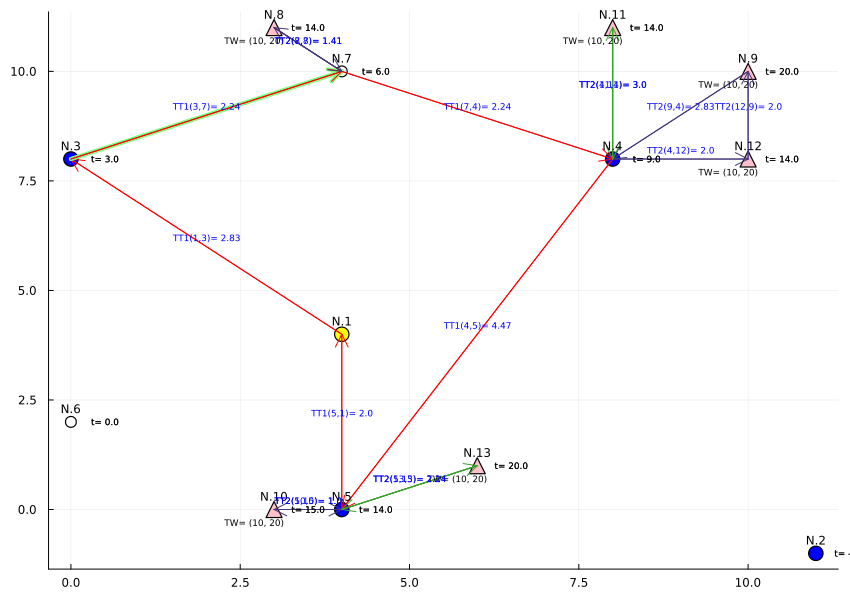

In [119]:
displayMap()
speed1_labels = [string("TT1(",i,",",j,")= ", round(value(TT1[i,j]), digits=2)) for i in N for j in N]
speed2_labels = [string("TT2(",i,",",j,")= ", round(value(TT2[i,j]), digits=2)) for i in N for j in N]
demand_labels = [string("TW= ",TW[i-1-np]) for i in C]

for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 

if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", round(value(t[i]))) for i in A2]
    SEV_labels = [string("z(",r,",",i,",",j,")= ", round(value(z[r,i,j]))) for r in V2 for i in A2 for j in A2]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(length(V2))
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
                mid_x = (x_coor[i] + x_coor[j]) / 2
                mid_y = (y_coor[i] + y_coor[j]) / 2 +0.2
                annotate!(mid_x, mid_y, text(speed1_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
            annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6))
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2 
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
                    # annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    annotate!(mid_x, mid_y, text(speed2_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
                end
            end
        end
    end
end
plot!()

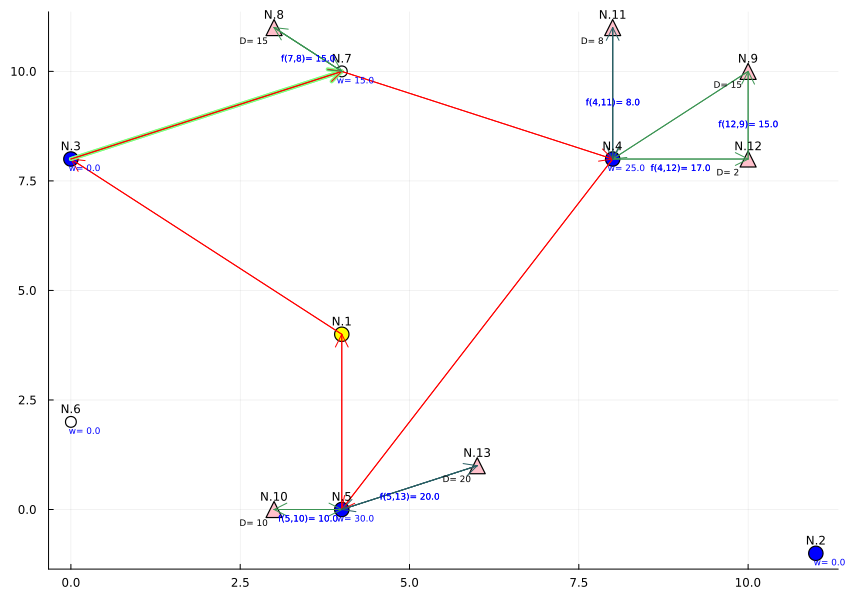

In [121]:
displayMap()
demand_labels = [string("D= ", D[i-1-np]) for i in C]
for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 


if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", value(t[i])) for i in A2]
    flow_labels = [string("f(",i,",",j,")= ", floor(value(f[i,j]))) for i in A2 for j in A2]
    loan_labels = [string("w= ", floor(value(w[i]))) for i in P]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(length(V2))
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
#             annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6))
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
#                     annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    
                end
                if value(f[i,j]) != 0
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                    annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
                end
            end
        end
    end
    
    for p in P
        annotate!(x_coor[p]+0.2,y_coor[p]-0.2, text(loan_labels[p-1],6 ,:blue))
    end
end
plot!()